# Import

In [64]:
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
from torch import FloatTensor, LongTensor
import math

In [65]:
from load_script_deep_framework import load_dataset

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
'Dataset plotting function'
def plot_output(train, all_output, permutation):
    plt.figure(figsize=(3,3))
    plt.scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)

# Loading the dataset

In [68]:
train,target_train = load_dataset()

In [69]:
test,target_test = load_dataset()

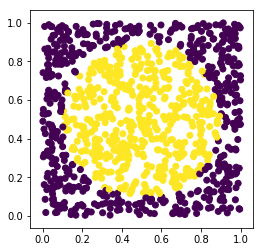

In [70]:
plt.figure(figsize=(4,4))
plt.scatter(test[:,0], test[:,1], c=target_test[:,1].numpy())
plt.show()

# Generic Module Class

In [71]:
class Module():
    '''General class structure from which to inherit'''
    def forward(self,input):
        raise NotImplemented
        
    def backward(self,input):
        raise NotImplemented
            
    def param(self):
        return []
    
    def __call__(self, *input):
        return self.forward(*input)

# Specific classes

In [72]:
class Linear(Module):
    '''Linear layer implementation, needs the number of inputs and number of units to call an instance.
    It initializes Gaussian weights with mean = 0 and std = 0.1.
    Bias terms are included in the weights matrix.'''
    def __init__(self, input_dimension, output_dimension):
        super(Linear,self).__init__()
        
        self._input_dimension = input_dimension
        self._output_dimension = output_dimension
    
        self._weights = torch.randn(self._output_dimension, self._input_dimension + 1)*1e-1

        self._gradient = torch.zeros(self._weights.shape)
    
    def forward(self, input):
        
        # Append '1' to input to be multiplied to bias term
        self._input = input.view(-1, self._input_dimension)
        self._batch_size = self._input.shape[0]
        self._input = torch.cat((self._input, torch.Tensor(self._input.shape[0]).fill_(1)), dim=1)
        self._output = self._input.mm(self._weights.t())
        
        return self._output.clone()
        
    def backward(self, d_dy):
        self._gradient.add_(d_dy.t().mm(self._input))
        
        # Narrowing is done to exclude bias terms in backprop.
        d_dx = d_dy.mm(self._weights.narrow(1, 0, self._input_dimension))
        
        return d_dx
    
    def param(self):
        return [self._weights, self._gradient]
    

In [73]:
class ReLU(Module):
    '''ReLU activation function class, it performs backward and forward pass.'''
    def __init__(self):
        super(ReLU,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.clone()
        self._output[self._output < 0] = 0

        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx = d_dy.clone()
        d_dx[self._input < 0] = 0
        
        return d_dx
        

In [74]:
class Tanh(Module):
    '''Tanh activation function class, it performs backward and forward pass.'''
    def __init__(self):
        super(Tanh,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.tanh()
        
        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx= (1 - self._input.tanh()**2).mul(d_dy)
        
        return d_dx
        

In [75]:
class LossMSE(Module):
    def __init__(self):
        super(LossMSE,self).__init__()
        
    def forward(self, input, target):
        '''Returns square error between input and target.'''
        self._input = input - target
        self._output = (self._input).pow(2).sum()
        return self._output
        
    def backward(self):
        d_dy = 2 * self._input
        return d_dy

In [76]:
class OptimSGD():
    def __init__(self, param, learning_rate, momentum=0, decay_rate=1):
        super(OptimSGD,self).__init__()
        
        self._learning_rate = learning_rate
        self._param = param
        self._momentum = momentum
        self._decay_rate = decay_rate
    
    def step(self):
        '''Computes an update step. Each parameter is a tuple if (parameter, gradient)'''
        try:
            update_old
        except:
            update_old = [0 for i in self._param]
        
        for i, param in enumerate(self._param):
            if param:
                update_current = self._momentum * update_old[i] - (1 - self._momentum) * self._learning_rate * param[1]
                param[0].add_(update_current)
                update_old[i] = update_current
        
    def zero_grad_(self):
        for param_grad in self._param:
            if param_grad:
                param_grad[1].zero_()
        
    def learning_rate_decay_step(self):
        self._learning_rate *= self._decay_rate
        
        

In [77]:
class Sequential(Module):
    '''Builds a neural network, takes a list of layers and activation functions + loss function when instantiated.
    Performs the forward pass for the input through all the layers and returns loss.
    Similarly performs backward pass.'''
    
    def __init__(self, modules ,loss):
        super(Sequential,self).__init__()
        
        self._modules = modules
        self._loss = loss
    
    def forward(self, input, target):
        
        y = input.clone()
        for module in self._modules:
            y = module(y)
        
        output = y.clone()
        
        loss = self._loss(y, target)
        
        return loss, output
    
    def backward(self):
        d_dy = self._loss.backward()
        
        for module in reversed(self._modules):
            d_dy = module.backward(d_dy)
    
    def param(self):
        
        param_list=[]
        
        for module in self._modules:
            if module.param():
                param_list.append(module.param())
                
        return param_list


In [78]:
def test_error():

    correct_test = 0

    # Forward pass
    loss, output = network(test, target_test)

    boolean_target = target_test[:,1] > target_test[:,0]
    boolean_output = output[:,1] > output[:,0]

    correct_test += sum(boolean_output == boolean_target)

    correct_test = (1000-correct_test)/1000 * 100
    print('Test error {} %'.format(correct_test))

    return correct_test

In [79]:
.97 ** 200

0.0022612410099957653

Epoch: 0. Train error: 49.6 %. Loss: 2.6280257142600605.
Test error 52.2 %
Epoch: 1. Train error: 49.0 %. Loss: 2.5553725304235706.
Test error 47.8 %
Epoch: 2. Train error: 48.6 %. Loss: 2.5205163031267004.
Test error 47.8 %
Epoch: 3. Train error: 52.5 %. Loss: 2.673686093829572.
Test error 47.8 %
Epoch: 4. Train error: 47.0 %. Loss: 2.4815971739515663.
Test error 52.2 %
Epoch: 5. Train error: 47.199999999999996 %. Loss: 2.3443747291667387.
Test error 52.2 %
Epoch: 6. Train error: 51.6 %. Loss: 2.5284098341343926.
Test error 52.2 %
Epoch: 7. Train error: 49.2 %. Loss: 2.4690480808708815.
Test error 52.2 %
Epoch: 8. Train error: 45.800000000000004 %. Loss: 2.381124322578311.
Test error 52.2 %
Epoch: 9. Train error: 52.7 %. Loss: 2.5607480097655206.
Test error 47.8 %
Epoch: 10. Train error: 49.9 %. Loss: 2.50345632904768.
Test error 52.2 %
Epoch: 11. Train error: 51.4 %. Loss: 2.5013804290238766.
Test error 52.2 %
Epoch: 12. Train error: 50.4 %. Loss: 2.4290797877274453.
Test error 47.8 

Epoch: 111. Train error: 50.1 %. Loss: 2.039156445980072.
Test error 52.2 %
Epoch: 112. Train error: 51.7 %. Loss: 2.056601282775402.
Test error 47.8 %
Epoch: 113. Train error: 48.4 %. Loss: 2.0252105842232706.
Test error 47.8 %
Epoch: 114. Train error: 49.1 %. Loss: 2.0311936147809027.
Test error 47.8 %
Epoch: 115. Train error: 48.9 %. Loss: 2.034450637936592.
Test error 52.2 %
Epoch: 116. Train error: 50.6 %. Loss: 2.044092365026474.
Test error 52.2 %
Epoch: 117. Train error: 51.4 %. Loss: 2.0391726348400114.
Test error 52.2 %
Epoch: 118. Train error: 49.4 %. Loss: 2.0304929443001747.
Test error 47.8 %
Epoch: 119. Train error: 47.699999999999996 %. Loss: 2.027236237704754.
Test error 47.8 %
Epoch: 120. Train error: 52.6 %. Loss: 2.0398845639824867.
Test error 52.2 %
Epoch: 121. Train error: 51.0 %. Loss: 2.040364786684513.
Test error 47.8 %
Epoch: 122. Train error: 48.6 %. Loss: 2.0244524448513985.
Test error 52.2 %
Epoch: 123. Train error: 52.0 %. Loss: 2.0460695035457612.
Test erro

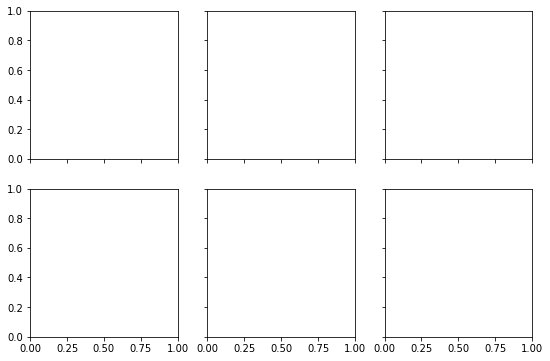

In [83]:
# Define the Neural Network
layers = [
    Linear(2,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,2),
    Tanh()
]
loss_function = LossMSE()
network = Sequential(layers, loss_function)

# Initial learning rate and decay rate
learning_rate = 2e-1
momentum = 0.1
decay_rate = 0.98

optimizer=OptimSGD(network.param(), learning_rate, momentum=momentum, decay_rate=decay_rate)

num_epochs = 200
mini_batch_size = 5

# Initialize lists to store training loss and test accuracy
train_loss = []
test_correct = []

# Define subplot for dataset visualization
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True, figsize = (9, 6))
ind = 0

for epoch in range(num_epochs):
    
    correct = 0
    loss_sum = 0
    
    # Randomize order for SGD
    permutation = torch.randperm(target_train.shape[0])
    
    train_batched = [train[permutation][i:(i+mini_batch_size),:] for i in range(train.shape[0]) if i % mini_batch_size == 0]
    target_batched = [target_train[permutation][i:(i+mini_batch_size),:] for i in range(train.shape[0]) if i % mini_batch_size == 0]
    
    for j, batch in enumerate(zip(train_batched, target_batched)):
        
        # Load sample
        train_element, target_element = batch
        
        # Forward pass
        loss, output = network(train_element, target_element)
        loss_sum += loss

        # Backward pass, gradient step and reinitalize gradient
        network.backward()
        #network.update_weights_(learning_rate)
        optimizer.step()
        optimizer.zero_grad_()

        # Training error
        boolean_target = target_element[:,1] > target_element[:,0]
        boolean_output = output[:,1] > output[:,0]
                
        correct += sum(boolean_output == boolean_target)
        
    train_loss.append(loss_sum/1000)

    optimizer.learning_rate_decay_step()
    
    if epoch % 1 == 0:
        print('Epoch: {}. Train error: {} %. Loss: {}.'.format(epoch ,(1000-correct)/1000*100, loss_sum/1000))
        
        test_correct.append(test_error())
        
    if epoch in [1, 10, 15, 25, 100, 499] and 0:
        axes[ind // 3, ind % 3].scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)
        ind += 1

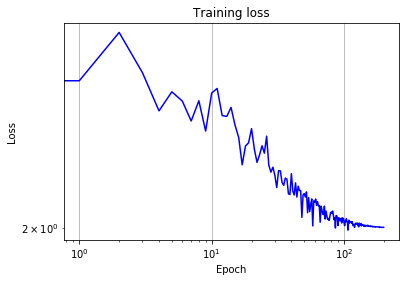

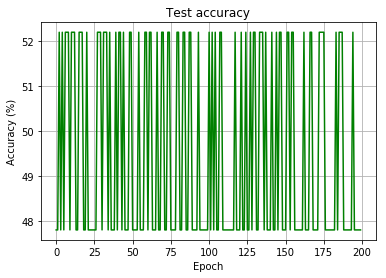

In [81]:
plt.figure("Train Loss")
plt.title("Training loss")
plt.loglog(train_loss, 'b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("figures/loss_loglog_2.eps", format="eps")

plt.figure("Test accuracy")
plt.title("Test accuracy")
plt.plot([100-i for i in test_correct], 'green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.savefig("figures/accuracy_2.eps", format="eps")

In [50]:
0.98 ** 200 * 2e-2

0.00035175893211443005